**Approach**: we read in normalized structure factors, propose values for $a$ and $b$ and calculate $r_{DW}$ based on $a$, $b$, and the estimated error in each normalized structure factor--all as described in notebooks **2** & **3**.

In [1]:
import matplotlib.pyplot as plt
import numpy   as np

In [2]:
import reciprocalspaceship as rs
from scipy.stats     import rice, foldnorm
from dw_tools        import fitting_dw, modify_ds

In [5]:
%autosave 300
# !cat /proc/meminfo | grep Mem
%load_ext autoreload
%autoreload 2
rs.__version__

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'0.9.5'

In [6]:
# path="double_wilson_data\\"   # Windows
path = "double_wilson_data/"    # Unix
mtz1 = "NECAT_HEWL_RT_NaI_82_XDS_scaled1"
ds1  = rs.read_mtz(path + mtz1 + "_scaled.mtz")
ds1.label_centrics(inplace=True);

The next few steps are probably unnecessary for ```NECAT_HEWL_RT_NaI_82_XDS_scaled1```.

In [8]:
# ds1.info()
EP_plus_label = "EP+_aniso_2"
EP_min_label  = "EP-_aniso_2"
dHKL_label = "dHKL"

Let's merge the Friedel normalized structure factors (if not yet done).

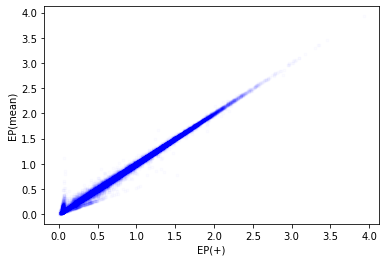

In [9]:
sigE_array = ds1[["SIG"+EP_plus_label, "SIG"+EP_plus_label]].to_numpy()
min_sig = np.percentile(sigE_array,1) # np.percentile flattens by default
w       = 1/(min_sig**2+sigE_array**2)
Ew      = np.nansum(w*ds1[[EP_plus_label, EP_min_label]].to_numpy(),axis=1)/np.nansum(w,axis=1)
sigEw   = (np.nansum(w,axis=1))**-0.5

EP_label= "EP_MEAN"
ds1[EP_label] = Ew
ds1[EP_label] = ds1[EP_label].astype("NormalizedSFAmplitude")
ds1["SIG"+EP_label] = sigEw
ds1["SIG"+EP_label] = ds1["SIG"+EP_label].astype("Stddev")

plt.plot(ds1[EP_plus_label],ds1["EP_MEAN"],'b.',alpha=0.01)
plt.xlabel("EP(+)"); plt.ylabel("EP(mean)"); plt.show()

We will start from $a$, $b$ which we'll assume based on the work we did in parts **2** and **3**.

In [14]:
a=0.99
b=0.05
ds1.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 33281 entries, (0, 0, 4) to (63, 2, 1)
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype                
---  ------              --------------  -----                
 0   FreeR_flag          33281 non-null  MTZInt               
 1   IMEAN               33281 non-null  Intensity            
 2   SIGIMEAN            33281 non-null  Stddev               
 3   I(+)                33281 non-null  FriedelIntensity     
 4   SIGI(+)             33281 non-null  StddevFriedelI       
 5   I(-)                33281 non-null  FriedelIntensity     
 6   SIGI(-)             33281 non-null  StddevFriedelI       
 7   N(+)                33281 non-null  MTZInt               
 8   N(-)                33281 non-null  MTZInt               
 9   FP+                 33281 non-null  FriedelSFAmplitude   
 10  FP-                 33281 non-null  FriedelSFAmplitude   
 11  SIGFP+              33281 non-null  StddevFrie

In [12]:
ds1=fitting_dw.eff_r_dw_per_hkl(ds1,a,b,label=EP_label, dHKL_label=dHKL_label, inplace=True);
modify_ds.check_col_dtypes(ds1)
ds1.write_mtz(path + mtz1 + "_scaled_w_rDW.mtz", skip_problem_mtztypes=True)

AttributeError: module 'reciprocalspaceship' has no attribute 'dtypes'

Bivariate priors conditioned on NE-CAT data.

In [ ]:
rx = ds1_2["r_DW_out_EP_MEAN"] # determine what these should actually be! (true-true) (obsd-true)?
r  = ds1_2["r_DW_out_EP_MEAN"]
E3 = ds1_2["EP_MEAN"]
R3 = r*E3
K  = R3**2/(1-r**2)
p1 = 2/(1-r**2)
v  = (rx-r**2)/(1-r**2)